In [4]:
import sys
import os
sys.path.append(os.path.abspath("../../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from models.forward.CNN_models import CNN, CNN_Heavy
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# データ読み込み
train_data = torch.load('../../data/datasets/data/darcy_train_16.pt')
test_data_16 = torch.load('../../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load('../../data/datasets/data/darcy_test_32.pt')
print(train_data.keys())

dict_keys(['x', 'y'])


In [8]:
x_train, y_train = train_data['x'], train_data['y']
x_test, y_test = test_data_16['x'], test_data_16['y']
x_train = x_train.unsqueeze(-1).permute(0, 3, 1, 2)
x_test = x_test.unsqueeze(-1).permute(0, 3, 1, 2)
y_train = y_train.unsqueeze(-1).permute(0, 3, 1, 2)
y_test = y_test.unsqueeze(-1).permute(0, 3, 1, 2)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_test = x_test.float().to(device)
y_test = y_test.float().to(device)
print(x_train.shape)  # → torch.Size([100, 1, 16, 16]) を想定
print(y_train.shape)  # 同上

batch_size = 16
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


torch.Size([1000, 1, 16, 16])
torch.Size([1000, 1, 16, 16])


In [ ]:
model = CNN_Heavy().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- 学習ループ ---
num_epochs = 100
patience = 10
best_val_loss = float("inf")
wait = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item() * xb.size(0)
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4e}, Val Loss = {avg_val_loss:.4e}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        # 保存処理(必要に応じてコメントアウト外す)
        # torch.save(model.state_dict(), "../../results/forward/best_cnn_heavy_model.pth")
        
        
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break




Epoch 0: Train Loss = 2.3944e-01, Val Loss = 3.0553e-02
Epoch 1: Train Loss = 1.9141e-02, Val Loss = 1.1921e-02
Epoch 2: Train Loss = 1.1784e-02, Val Loss = 8.5882e-03
Epoch 3: Train Loss = 9.8715e-03, Val Loss = 6.6972e-03
Epoch 4: Train Loss = 8.0142e-03, Val Loss = 6.4004e-03
Epoch 5: Train Loss = 7.7184e-03, Val Loss = 6.2000e-03
Epoch 6: Train Loss = 6.4535e-03, Val Loss = 5.3836e-03
Epoch 7: Train Loss = 6.3859e-03, Val Loss = 5.0026e-03
Epoch 8: Train Loss = 5.0190e-03, Val Loss = 5.6643e-03
Epoch 9: Train Loss = 4.6868e-03, Val Loss = 5.1783e-03
Epoch 10: Train Loss = 4.2878e-03, Val Loss = 6.1684e-03
Epoch 11: Train Loss = 3.9729e-03, Val Loss = 3.5274e-03
Epoch 12: Train Loss = 3.4919e-03, Val Loss = 3.8046e-03
Epoch 13: Train Loss = 3.3721e-03, Val Loss = 5.7476e-03
Epoch 14: Train Loss = 3.1187e-03, Val Loss = 3.2330e-03
Epoch 15: Train Loss = 2.7253e-03, Val Loss = 3.4076e-03
Epoch 16: Train Loss = 2.8361e-03, Val Loss = 3.1650e-03
Epoch 17: Train Loss = 2.2447e-03, Val Lo

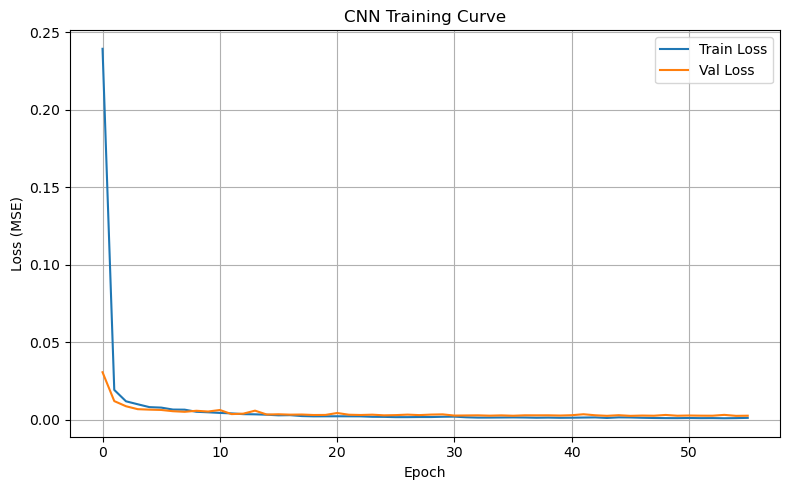

In [11]:
# #学習曲線の可視化

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("CNN Training Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("training_curve.png")  # ← 描画せず保存！

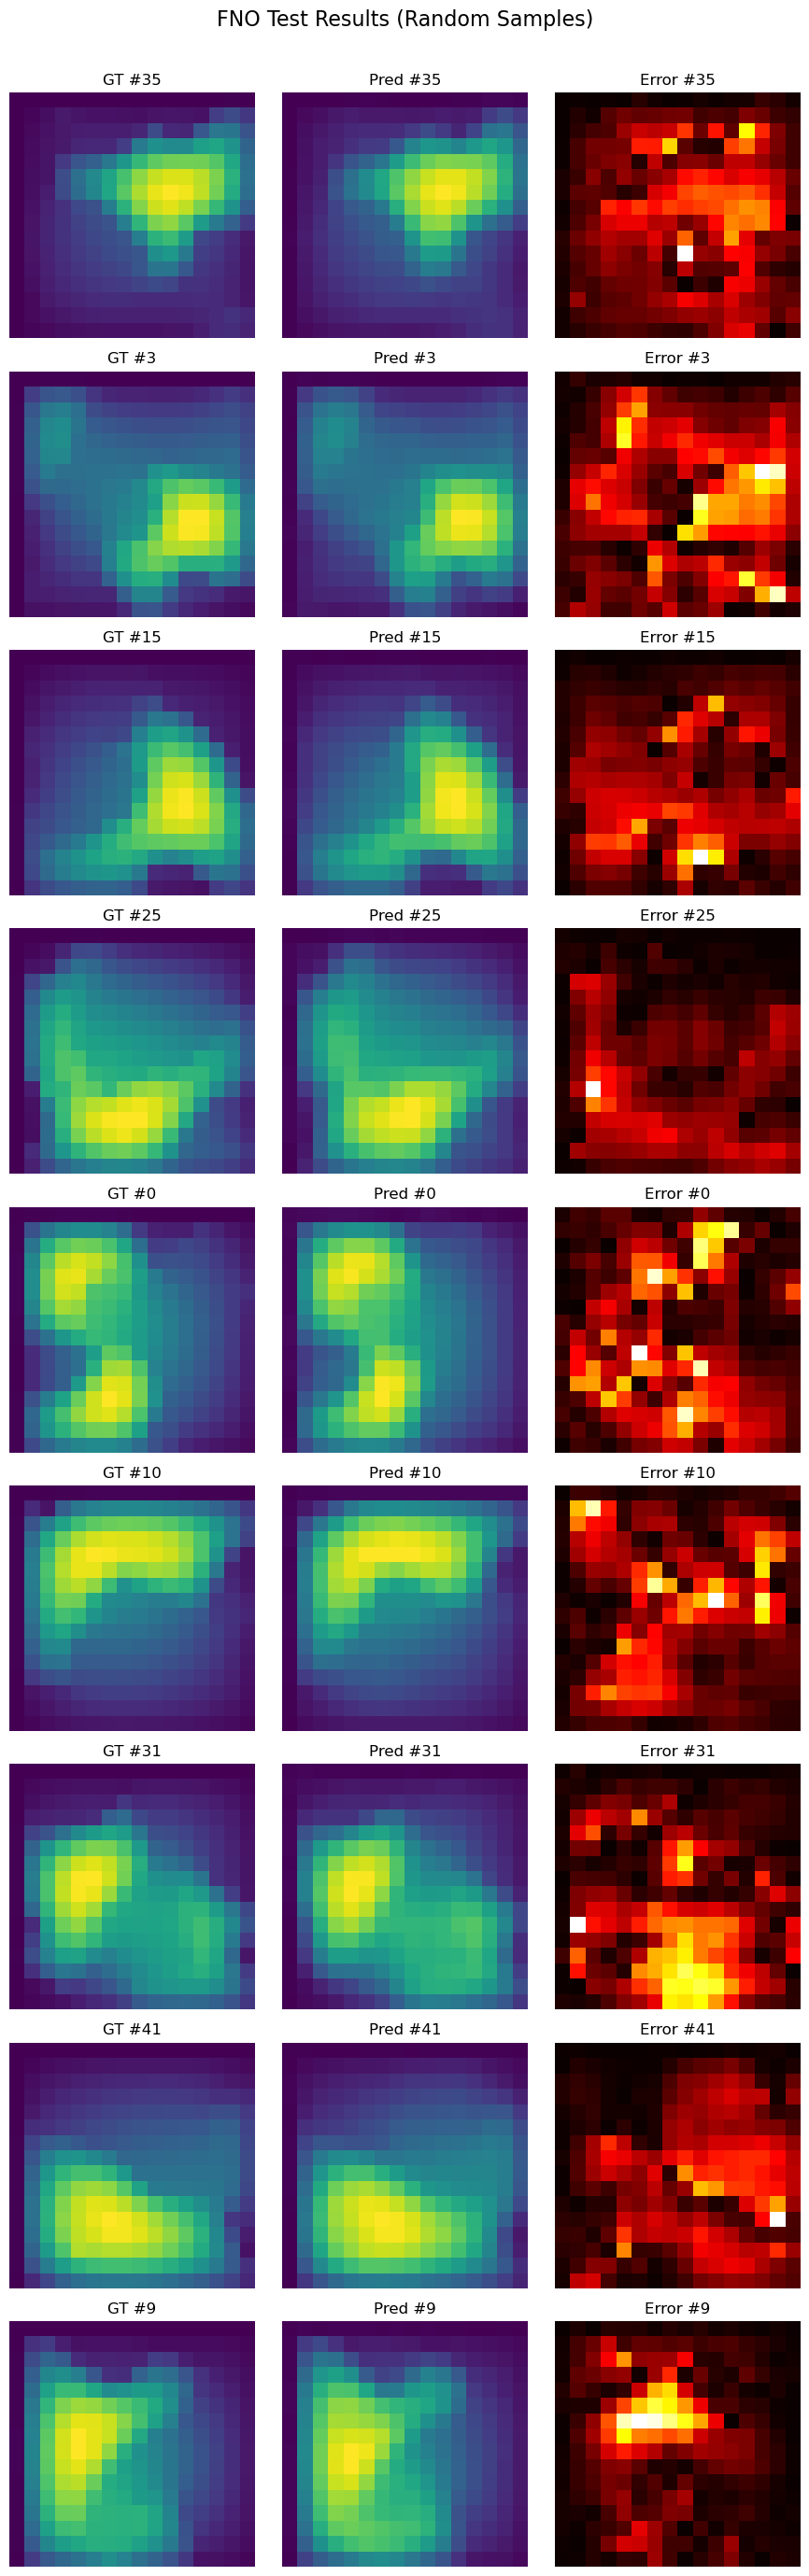

In [12]:
model.eval()
with torch.no_grad():
    pred_test = model(x_test)

# NumPy化
p = pred_test.cpu().numpy()
y = y_test.cpu().numpy()

# ランダムに表示数選ぶ（例：9枚）
num_samples = 9
indices = np.random.choice(len(y), size=num_samples, replace=False)

# 可視化
fig, axs = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))

for i, idx in enumerate(indices):
    gt = y[idx, 0]      # [H, W]
    pred = p[idx, 0]    # [H, W]
    err = np.abs(gt - pred)

    axs[i, 0].imshow(gt, cmap='viridis')
    axs[i, 0].set_title(f"GT #{idx}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(pred, cmap='viridis')
    axs[i, 1].set_title(f"Pred #{idx}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(err, cmap='hot')
    axs[i, 2].set_title(f"Error #{idx}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.suptitle("FNO Test Results (Random Samples)", fontsize=16, y=1.02)
plt.show()
